In [17]:
import torch
import torchvision
from lib.fcn import FCN

In [18]:
gpu_name = "cuda:0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
path = "model/FCN_MNIST_DROP"
model = FCN()
model.load_state_dict(torch.load(path, map_location=gpu_name))
model = model.to(device)

In [20]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
])
_mnist = torchvision.datasets.MNIST(root='data/mnist', train=False,
                                    download=True, transform=transform)
mnist = torch.utils.data.DataLoader(_mnist, batch_size=32,
                                    shuffle=False, num_workers=2)

_fmnist = torchvision.datasets.FashionMNIST(root='data/fmnist', train=False,
                                            download=True, transform=transform)
fmnist = torch.utils.data.DataLoader(_fmnist, batch_size=32,
                                    shuffle=False, num_workers=2)

In [21]:
total_m_max = None
total_f_max = None

model.train()
for m_data, f_data in zip(mnist, fmnist):
    m_inputs, _ = m_data
    f_inputs, _ = f_data
    m_inputs, f_inputs = m_inputs.to(device), f_inputs.to(device)
    
    m_max = None
    f_max = None
    for i in range(5): 
        tmp_m_max = torch.softmax(model(m_inputs), dim=1).max(1)[0]
        tmp_f_max = torch.softmax(model(f_inputs), dim=1).max(1)[0]
        
        if m_max is None:
            m_max = tmp_m_max
            f_max = tmp_f_max
        else:
            m_max = m_max + tmp_m_max
            f_max = f_max + tmp_f_max
    m_max /= 5
    f_max /= 5
            
    if total_m_max is None:
        total_m_max = m_max
        total_f_max = f_max
    else:
        total_m_max = torch.cat((total_m_max, m_max), dim=0)
        total_f_max = torch.cat((total_f_max, f_max), dim=0)

In [22]:
total_m_max = total_m_max.detach().cpu().numpy()
total_f_max = total_f_max.detach().cpu().numpy()

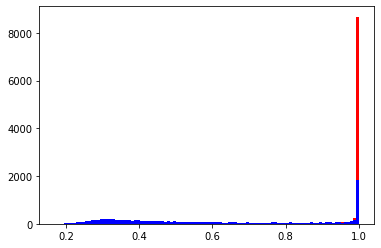

In [23]:
import matplotlib.pyplot as plt
plt.hist(total_m_max, bins=100, color='r')
plt.hist(total_f_max, bins=100, color='b')
plt.show()

In [24]:
import numpy as np
from sklearn.metrics import roc_auc_score
y_true = np.concatenate((np.zeros(10000), np.ones(10000)), axis=0)
y_score = np.concatenate((total_f_max, total_m_max), axis=0)

print(roc_auc_score(y_true, y_score))


0.88977144
